# Decision Tree

## Q1:

$$ \mu_1, ..,\mu_K \ge 0, \sum_{k=1}^K \mu_k = 1 $$

Solve the minimum value of $$\sum_{k=1}^K \mu_k^2 $$

using Larange Multiplier, $$ L(\mu_1,\mu_2,..,\mu_K,\lambda) = \sum_{k=1}^K \mu_k^2 + \lambda (\sum_{k=1}^K \mu_k - 1) $$

Hence, 

$$ \frac{\partial{L}}{\mu_k} = 2\mu_k + \lambda = 0 $$

$$ \sum_{k=1}^K \mu_k - 1 = 0$$

So,when $ \mu_1 = .. = \mu_K = \frac{1}{K},\lambda = \frac{-2}{K} $ 是拉格朗日函数的稳定点。

判断最大最小值，即判断拉格朗日函数的极值：

$ \frac{D^2L}{\partial \mu_i \partial \mu_j } = 2[[i == j]] + 0[[i!=j]]$

$ \frac{D^2L}{\partial \mu_i \partial \lambda } = 1, \frac{D^2L}{\partial \lambda^2 } = 0 $

所以这个矩阵是半正定矩阵，无法证明是否是最值。

假设是最值，不可能是最大值，那么当$ \mu_1 = .. = \mu_K = \frac{1}{K} $ 时，取到最小值。

## Q2：
For regression error, $$ impurity(D) = \frac{1}{N} \sum_{n=1}^N (y_n - \bar{y})^2 $$

in this dataset, $$ \bar{y} = \mu_{+} * 1 + \mu_{-} * (-1) = \mu_+ - \mu_-$$

So $$ impurity(D) = \frac{1}{N} N * \mu_+ (1 - (\mu_+ - \mu_-))^2 +  \frac{1}{N} N * \mu_- (-1 - (\mu_+ - \mu_-))^2  $$

$$ = \mu_+ (1 - (\mu_+ - \mu_-))^2 + \mu_- (-1 - (\mu_+ - \mu_-))^2  $$

$$ = 1 - (\mu_+ - \mu_-)^2 $$

$$ = 1 - \mu_+^2 - \mu_-^2 + 2\mu_+\mu_-  $$

For comparation, in classification, Gini impurity is $ 1 - \mu_+^2 - \mu_-^2 $



# Random Forest
## Q3:

For a given $(x_n,y_n)$, the proability that it will not be sampled is 

$$ (\frac{N-1}{N})^{pN} =  \frac{1}{(\frac{N}{N-1})^{pN} } = \frac{1}{(1 + \frac{1}{N-1})^{N*p}} \rightarrow_{N->\infty} e^{-p} $$

So for the N examples, there are approximately $ e^{-p} * N $ examples will not be exampled at all.

## Q4:

$$ G(X) = sign(\frac{1}{K} \sum_{k=1}^K g_k(X)) $$

For the out of sample Dataset,$D = (X,y)$

$$ E_{out}(g_k(X)) = mean(g_k(X) != y) = e_k \ for \ k \in [1,K].$$


# Experiments with Decision Trees
## Q11,12,13

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotDT import createPlot

def data_form(path,bias=False):
    # 导入数据
    D = np.loadtxt(path)

    X = D[:,:-1].astype('float') # 一定要是float格式才可以
    if bias: X = np.c_[np.ones(X.shape[0]),X]
    y = D[:,-1].copy()

    return X,y

def impurity(y):
    # 计算当前dataset的impurity，利用Gini index
    C = np.unique(y)
    sum_ = 0
    for c in C:
        frac = np.mean(y == c)
        sum_ += frac ** 2
    
    impurity = 1 -sum_
    return impurity 

def get_error(x,y,weights,theta,s):
    # 此时的error应该是impurity 
    # 使用Gini index，给定了 h = s * sign(x-theta) 这个分类后，返回｜D_c with h| * impurity (Dc with h)

    D = [y[x<=theta],y[x>theta]]
    
    sum_ = 0
    for i in range(len(D)):
        now_y = D[i]
        # impurity 
        weight = len(now_y)/len(y)
        sum_ += weight * impurity(now_y)
    
    return sum_ 

def decision_stump_1d(x,y,weights):
    # 一维decision stump算法，对x_i, 遍历theta 和 s，找出最优
    
    # x.shape = N,1
    
    N,d = X.shape
    
    min_err = 1e8
    best_s = 0
    best_theta = 0
    best_dim = -1
    

    thetas = (x[:-1] + x[1:])/2
        
    for s in [1,-1]:
        for theta in thetas: 
            err = get_error(x,y,weights,theta,s)

            if err < min_err: 
                min_err = err
                best_s = s
                best_theta = theta

    return [min_err,best_s,best_theta]

def decision_stump(X,y,weights):
    # 遍历每一维最优的s和theta，选出最优
    min_err = 1e8
    best_s = 0
    best_theta = 0
    best_dim = -1
    
    for dim in range(X.shape[1]):
     
        x = X[:,dim]
        [err,s,theta] = decision_stump_1d(x,y,weights)
        
        if err < min_err:
            min_err = err
            best_s = s
            best_theta = theta
            best_dim = dim
            
    return [min_err,best_s,best_theta,best_dim]

class TreeNode:
    def __init__(self,x,left,right):
        self.val = x
        self.left = left
        self.right = right
    
def decision_tree(X,y,depth,max_depth):    
    # 决策树算法
    
    # base case
    if X.shape[0] == 0: 
        return None
    elif abs(np.mean(y)) == 1:
        return TreeNode({'leaf':y[0]},None,None)
    elif depth >= max_depth: # 深度剪枝
        if sum(y==1) > sum(y==-1):
            return TreeNode({'leaf':1},None,None)
        else:
            return TreeNode({'leaf':-1},None,None)
    else:
        # 如果不是base case，找出最优的分割点
        weights = np.ones((X.shape[0]))
        [min_err,best_s,best_theta,best_dim] = decision_stump(X,y,weights) #g1
  
        # 对dataset进行分割，并进行递归
        X1,y1 = X[X[:,best_dim] <= best_theta],y[X[:,best_dim] <= best_theta]
        X2,y2 = X[X[:,best_dim] > best_theta],y[X[:,best_dim] > best_theta]
        G1 = decision_tree(X1,y1,depth+1,max_depth)
        G2 = decision_tree(X2,y2,depth+1,max_depth)

        model = {'Gini':min_err,'s':best_s,'theta':best_theta,'feature':best_dim}
        res = TreeNode(model,G1,G2)
        
    return res

def predict(X,root):
    # 递归预测
    y_predict = np.zeros((X.shape[0]))
    
    if len(root.val) > 1:
        dim = root.val['feature']
        theta = root.val['theta']

        tmp = (X[:,dim] <= theta) # <= theta 的数据集
        y_predict[tmp] = predict(X[tmp],root.left)
        y_predict[~tmp] = predict(X[~tmp],root.right)
    else:
        y_predict += root.val['leaf']
        
    return y_predict

def plot_lines(root,hmin,hmax,vmin,vmax):
    # 递归来画决策线
    if root.val['feature'] == 0: 
        plt.vlines(root.val['theta'],vmin,vmax)
        if root.left and len(root.left.val) > 1: plot_lines(root.left,hmin,root.val['theta'],vmin,vmax)
        if root.right and len(root.right.val) > 1: plot_lines(root.right,root.val['theta'],hmax,vmin,vmax)

    else: 
        plt.hlines(root.val['theta'],hmin,hmax)
        if root.left and len(root.left.val) > 1: plot_lines(root.left,hmin,hmax,vmin,root.val['theta'])
        if root.right and len(root.right.val) > 1: plot_lines(root.right,hmin,hmax,root.val['theta'],vmax)
        
    return 

def plot(X,y,root):
#     fig = plt.figure(figsize=(10,8))
    plt.scatter(X[y==1,0],X[y==1,1],marker='o',color='red')
    plt.scatter(X[y==-1,0],X[y==-1,1],marker='x',color='blue')
    
    plot_lines(root,0,1,0,1)
    
    plt.show()

ImportError: cannot import name 'createPlot' from 'plotDT' (/Users/yulinwu/Documents/engineering/machine learning/技法/hw3/plotDT.py)

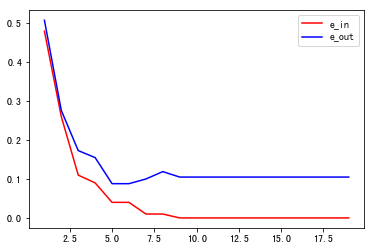

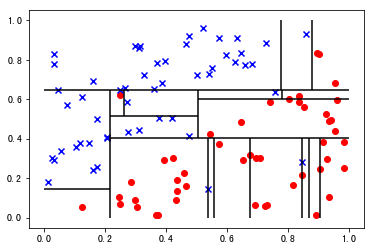

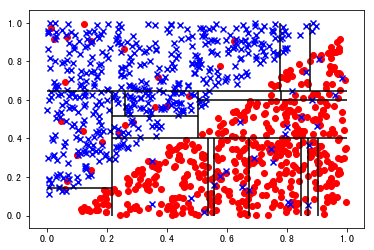

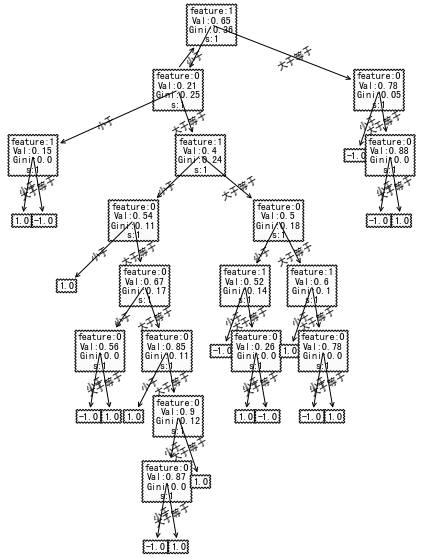

In [14]:
X,y = data_form('hw3_train.dat.txt')
X_test,y_test = data_form('hw3_test.dat.txt')

weights = np.ones((X.shape[0]))

max_depth_lst = range(1,20)
e_in = np.zeros((len(max_depth_lst)))
e_out = np.zeros((len(max_depth_lst)))
i = 0
for max_depth in max_depth_lst:
    root = decision_tree(X,y,1,max_depth)
    y_predict = predict(X,root)
    y_predict_test = predict(X_test,root)
    e_in[i] = np.mean(y_predict != y)
    e_out[i] = np.mean(y_predict_test != y_test)
    i += 1

plt.plot(max_depth_lst,e_in,color='red',label='e_in')
plt.plot(max_depth_lst,e_out,color='blue',label='e_out')
plt.legend()
plt.show()

plot(X,y,root)
plot(X_test,y_test,root)
createPlot(root)

# Random Forest
## Q14,15,16

In [15]:
def bootstrap(X,y,p=1):
    """
    p: resample p * N examples out of N examples
    returns:
    resampled X,resampled y 
    """
    # bagging中，对于每一个g，bootstrap来构造新的dataset作为input
    N = X.shape[0]
    boot_lst = []
    for i in range(len(X)):
        boot_lst.append(int(np.floor(np.random.random()*p*N)))
    now_X = X[boot_lst]
    now_y = y[boot_lst]
    return now_X,now_y

In [40]:
tree_num = 30000 # 树的数量
y_predict = np.zeros((len(y)))
y_predict_test = np.zeros((len(y_test)))
e_in = np.zeros((tree_num))
e_out = np.zeros((tree_num))

for i in range(tree_num):
    # bagging的精髓是bootstrapping:
    # 做tree_num次bootstrapping，即有tree_num个g
    now_X,now_y = bootstrap(X,y,0.8)
    now_root = decision_tree(X,now_y,1,20)
    y_predict += predict(X,now_root)
    y_predict_test += predict(X_test,now_root)
    
    tmp = np.sign(y_predict/(i+1))
    tmp1 = np.sign(y_predict_test/(i+1))

    e_in[i] = np.mean(tmp != y)
    e_out[i] =np.mean(tmp1 != y_test)
    
    if (i+1) % 500 == 1: 
        print('now there is %d tree' % i)
        print('e_in is %f1' % e_in[i],end='\t')
        print('e_out is %f \n' % e_out[i]) 
        
    if i >= 100 and e_in[i] - e_in[i-100] < 1e-8:
        break;

now there is 0 tree
e_in is 0.5600001	e_out is 0.506000 

now there is 500 tree
e_in is 0.4700001	e_out is 0.502000 

now there is 1000 tree
e_in is 0.4800001	e_out is 0.526000 

now there is 1500 tree
e_in is 0.4600001	e_out is 0.512000 

now there is 2000 tree
e_in is 0.4600001	e_out is 0.508000 

now there is 2500 tree
e_in is 0.4800001	e_out is 0.505000 

now there is 3000 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 3500 tree
e_in is 0.4800001	e_out is 0.509000 

now there is 4000 tree
e_in is 0.4800001	e_out is 0.506000 

now there is 4500 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 5000 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 5500 tree
e_in is 0.4800001	e_out is 0.509000 

now there is 6000 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 6500 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 7000 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 7500 tree
e_in is 0.4800001	e_out is 0.508000 

now there is 8000 tree
e_in 

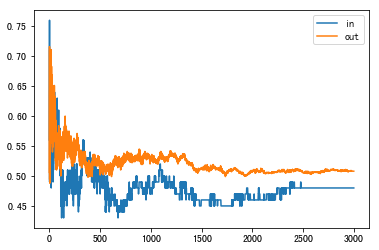

In [44]:
plt.plot(e_in[:3000],label='in')
plt.plot(e_out[:3000],label='out')
# plt.text(tree_num,e_in[-1],str(e_in[-1]))
# plt.text(tree_num,e_out[-1],str(e_out[-1]))
plt.legend()
plt.show()